## 朴素贝叶斯分类器

朴素贝叶斯为生成模型，学习联合概率分布。

条件独立性假设：
$$
p(X_1,X_2,...,X_n\mid Y)=p(X_1\mid Y)\cdot p(X_2\mid Y)\cdots p(X_n\mid Y)
$$

用概率图表示为：

![](../../imgs/ml/pgm/朴素贝叶斯概率图.png)

则联合概率分布为：
$$
p(X_1,X_2,...,X_n,Y)=p(Y)\prod_{i=1}^np(X_i\mid Y)
$$

其中 $X_1, X_2, ..., X_n$ 代表 $X$ 的 n 个属性。

预测时：
$$
p(Y \mid X_1, X_2, ..., X_n) = \frac{p(X_1, X_2, ..., X_n, Y)}{p(X_1, X_2,..., X_n)}
$$

而 $p(X_1, X_2, ..., X_n)$ 可看作定值。
$$
p(X_1, X_2, ..., X_n, Y) = p(Y)p(X_1, X_2, ..., X_n \mid Y)
$$
根据条件独立上式可以化为：
$$
p(Y \mid X_1, X_2, ..., X_n) = \frac{p(Y)\prod_{i=1}^{n} p(X_i\mid Y)}{p(X)}
$$

所以，朴素贝叶斯分类器可以定义如下：

$$
f(x)=arg\max_{c_k}P(Y=c_k)\prod_{i=1}^nP(X_i=x_i\mid Y=c_k)
$$  

这里 $c_k(k=1,2,...,K)$ 表示分类器所属的类别。

### 参数估计
对于朴素贝叶斯中参数 $p(Y=c_k)$ 以及 $p(X_i=x_i\mid Y=c_k)$ 可以通过极大似然估计来学习，下面直接写估计结果

** 1. 求解 $p(Y=c_k)$**

$$
p(Y=c_k)=\frac{\sum_{i=1}^NI(y_i=c_k)}{N},k=1, 2, ..., K, N \text{表示样本量}
$$

** 2. 求解 $p(X_i=x_i\mid Y=c_k)$**
假设第 $i$ 个特征可能的取值为 $A_i=\{a_{i1},a_{i2},...,a_{iS_i}\}$，所以有 $x_i=a_{il}\in A_i$，所以：

$$
p(X_i=x_i\mid Y=c_k)=p(X_i=a_{il}\mid Y=c_k)=\frac{\sum_{j=1}^NI(x_i^j=a_{il},y_i=c_k)}{\sum_{i=1}^nI(y_j=c_k)}
$$

In [8]:
# test digitize
import numpy as np

a = np.array([-1, -9.0, 0, 1, 3.2, 3, 9.0, 11.0, 17.0])
bins = np.array([0, 1, 2, 4, 7, 10])
re_ = np.digitize(a, bins)
print(re_)

[0 0 1 2 3 3 5 6 6]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.insert(0, os.path.abspath('../'))
from src import utils
from src.utils import DataBinWrapper
%matplotlib inline

class NaiveBayesClassifier:

    def __init__(self, max_bins=10):
        # 为了计算方便 对 x 每一维特征分箱
        self.dbw = DataBinWrapper(max_bins=max_bins)
        # 模型参数
        self.default_y_prob = None
        self.default_x_prob = {}
        self.p_y = {}  # p(y)
        self.p_x_y = {}  # p(x|y)
        self.class_num = None

    def fit(self, X, y):
        self.default_y_prob = np.log(0.5 / (y.max() + 1))
        # 分箱
        self.dbw.fit(X)
        x_bins = self.dbw.transform(X)
        # print(x_bins.shape)  # (400, 2)
        self.class_num = y.max() + 1
        for y_index in range(0, self.class_num):
            # p(y)
            y_n_sample = np.sum(y == y_index)
            self.default_x_prob[y_index] = np.log(0.5 / y_n_sample)
            x_y = x_bins[y == y_index]
            self.p_y[y_index] = np.log(y_n_sample / (self.class_num + len(y)))
            self.p_x_y[y_index] = {}
            # p(x | y)
            for i in range(0, x_y.shape[1]):
                self.p_x_y[y_index][i] = {}
                x_i_feature_set = set(x_y[:, i])
                for x_feature in x_i_feature_set:
                    self.p_x_y[y_index][i][x_feature] = np.log(
                        np.sum(x_y[:, i] == x_feature) / (y_n_sample + len(x_i_feature_set)))

    def predict_proba(self, x):
        x_bins = self.dbw.transform(x)
        rst = []
        for x_row in x_bins:
            tmp = []
            for y_index in range(0, self.class_num):
                try:
                    p_y_log = self.p_y[y_index]
                except:
                    p_y_log = self.default_y_prob
                for i,xij in enumerate(x_row):
                    try:
                        p_y_log += self.p_x_y[y_index][i][xij]
                    except:
                        p_y_log += self.default_x_prob[y_index]
                tmp.append(p_y_log)
            rst.append(tmp)
        return utils.softmax(np.asarray(rst))

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)
        

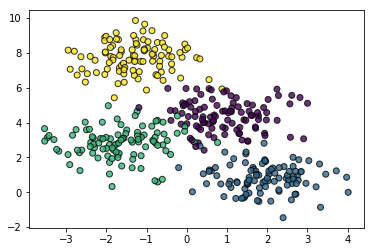

In [5]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)

# print(X.shape, y.shape)
plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

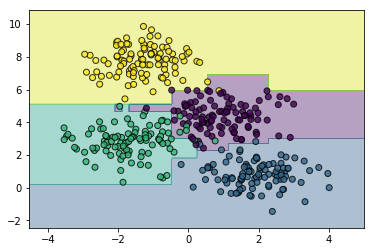

In [6]:
nb = NaiveBayesClassifier(max_bins=20)
nb.fit(X, y)
utils.plot_decision_function(X, y, nb)